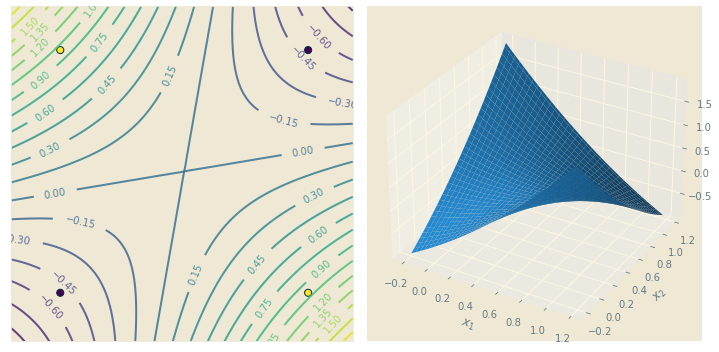

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


class KPerceptron(object):

    def __init__(self, ker='poly', gamma=1, coef0=1, degree=2, eta0=1.0, max_iter=100):
        self.ker = getattr(self, ker)
        self.gamma, self.coef0, self.degree = gamma, coef0, degree
        self.eta0, self.max_iter = eta0, max_iter

    def linear(self, Z):  # (|Z|,|SV|), linear = <Z,sv>
        sv = self.sv[self.sv_index]
        return np.dot(Z, sv.T)

    def poly(self, Z):  # (|Z|,|SV|), poly = (γ <Z,sv> + c)^d
        return (self.gamma * self.linear(Z) + self.coef0)**self.degree

    def rbf(self, Z):  # (|Z|,|SV|), rbf = exp(-2 γ |Z-sv|^2)
        sv = self.sv[self.sv_index]
        sv_norm = (sv**2).sum(axis=1)  # (|SV|,)
        Z_norm = (Z**2).sum(axis=1)  # (|Z|,)
        return np.exp(-2*self.gamma * (Z_norm.reshape(Z.shape[0], 1) - 2*self.linear(self, Z) + sv_norm))  # 用到了广播机制

    def decision_function(self, Z):  # 对Z的预测值
        return np.dot(self.ker(Z), self.alpha[self.sv_index])

    def fit(self, X, y, classes=None):
        m = X.shape[0]  # 样本数
        for k in range(self.max_iter):
            if not hasattr(self, 'sv'):
                self.alpha = np.zeros(m)
                self.sv_index = np.zeros(m, dtype=bool)
                self.sv = X
            indexes = np.random.permutation(m)  # 随机打乱样本顺序
            stop = True
            for i in np.arange(0, m):
                xi, yi = X[indexes[i], :], y[indexes[i]]
                if yi * self.decision_function(xi) <= 0:  # 预测错误 更新模型
                    self.alpha[indexes[i]] = self.alpha[indexes[i]] + yi * self.eta0
                    stop = False
                if self.alpha[indexes[i]] != 0:
                    self.sv_index[indexes[i]] = True
                else:
                    self.sv_index[indexes[i]] = False
            if stop:
                # print('模型在第%d轮训练完毕' % (i+1))
                return

        # print('达到最大迭代轮数')

    def predict(self, Z):
        return np.sign(self.decision_function(Z))

    def score(self, Z, y):
        return np.sum(self.predict(Z) == y) / float(y.size)


if __name__ == '__main__':
    X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]])
    y = np.array([-1, 1, 1, -1])

    np.random.seed(1)

    figure = plt.figure(figsize=(10, 5))

    with plt.style.context('Solarize_Light2'):

        x_min, x_max = -0.2, 1.2
        y_min, y_max = -0.2, 1.2
        h = .02
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        ax = plt.subplot(1, 2, 1)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        kp = KPerceptron(ker='poly', gamma=1, coef0=1, degree=2, eta0=0.5)
        kp.fit(X, y)
        acc = kp.score(X, y)

        Z = kp.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        contours = ax.contour(xx, yy, Z, 20, alpha=.8)
        ax.clabel(contours)
        ax.scatter(X[:, 0], X[:, 1], s=50, c=y, edgecolors='#002b36')

        ax = plt.subplot(1, 2, 2, projection='3d')
        ax.plot_surface(xx, yy, Z)

        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')

    plt.tight_layout()
    plt.show()
